In [1]:
# Add the root to sys.path so Python can find the src folder
import sys
import os
sys.path.append(os.path.abspath(".."))

from src import load_csv

# Load the Benin dataset
df_benin = load_csv('benin-malanville.csv')
df_benin.head()


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


#### loading
>as we already initalize load in 'src/__init__.py' first we call and load a file

In [2]:
from src import   missing_value_report
# Missing data
missing = missing_value_report(df_benin)
print(missing["missing_counts"])
print("Columns with >5% nulls:", missing["high_null_columns"])

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64
Columns with >5% nulls: ['Comments']


### missing value
we can see that there is no missing column except comment which is empty column so better to drop it 

In [3]:
# Drop 'Comments' column if all values are NaN or it's just empty
if 'Comments' in df_benin.columns and df_benin['Comments'].isna().all():
    df_benin.drop(columns='Comments', inplace=True)


In [4]:
from src import summary_statistics

# Summary stats
print(summary_statistics(df_benin))

                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0.000000      24.2000

#### explanation of the above statstics
it is shown that GHI            DNI           and DHI have a -ve value which is unacceptable as the minimum value is 0

In [5]:
irradiance_cols = ['GHI', 'DNI', 'DHI']
neg_counts = (df_benin[irradiance_cols] < 0).sum()
print("Negative value counts before clipping:\n", neg_counts)

Negative value counts before clipping:
 GHI    258847
DNI    275987
DHI    259182
dtype: int64


C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\3921238072.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[['GHI', 'DNI', 'DHI']].resample('H').mean()


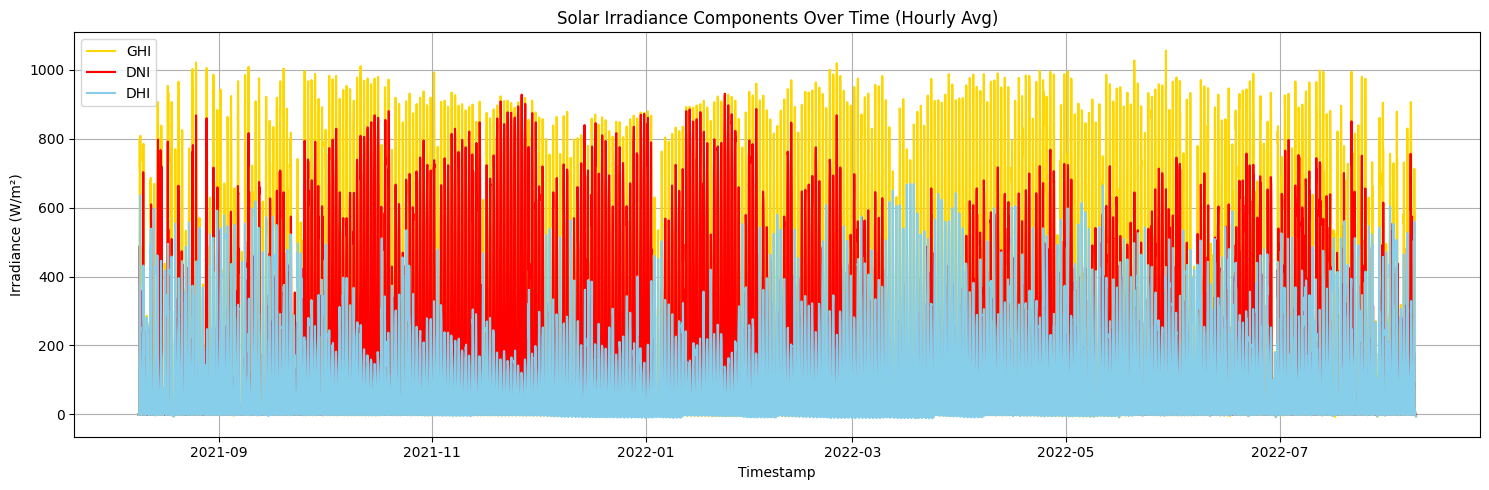

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


df_benin['Timestamp'] = pd.to_datetime(df_benin['Timestamp'])
df_benin.set_index('Timestamp', inplace=True)

# Optional: Resample to hourly average to reduce noise
df_hourly = df_benin[['GHI', 'DNI', 'DHI']].resample('H').mean()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly['GHI'], label='GHI', color='gold')
plt.plot(df_hourly.index, df_hourly['DNI'], label='DNI', color='red')
plt.plot(df_hourly.index, df_hourly['DHI'], label='DHI', color='skyblue')

plt.title('Solar Irradiance Components Over Time (Hourly Avg)')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Negative Irradiance Values Summary

| **Feature** | **# of Negative Values** | **% of Total Rows** |
|-------------|---------------------------|----------------------|
| **GHI**     | 258,847                   | ~49.3%               |
| **DNI**     | 275,987                   | ~52.5%               |
| **DHI**     | 259,182                   | ~49.3%               |

---

###  Interpretation

Negative values in irradiance data can be caused by:

-  **Nighttime readings**, when solar radiation should naturally be **0**, not negative.
-  **Sensor bias or drift**, where instruments slightly **dip below zero** due to low signal or calibration issues — especially at night.

While this behavior is **not abnormal in raw solar data**, negative irradiance values should be:
- **Cleaned by clipping them to 0** before analysis or modeling.
- This ensures physical accuracy and avoids misleading statistical summaries or visualizations.


C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


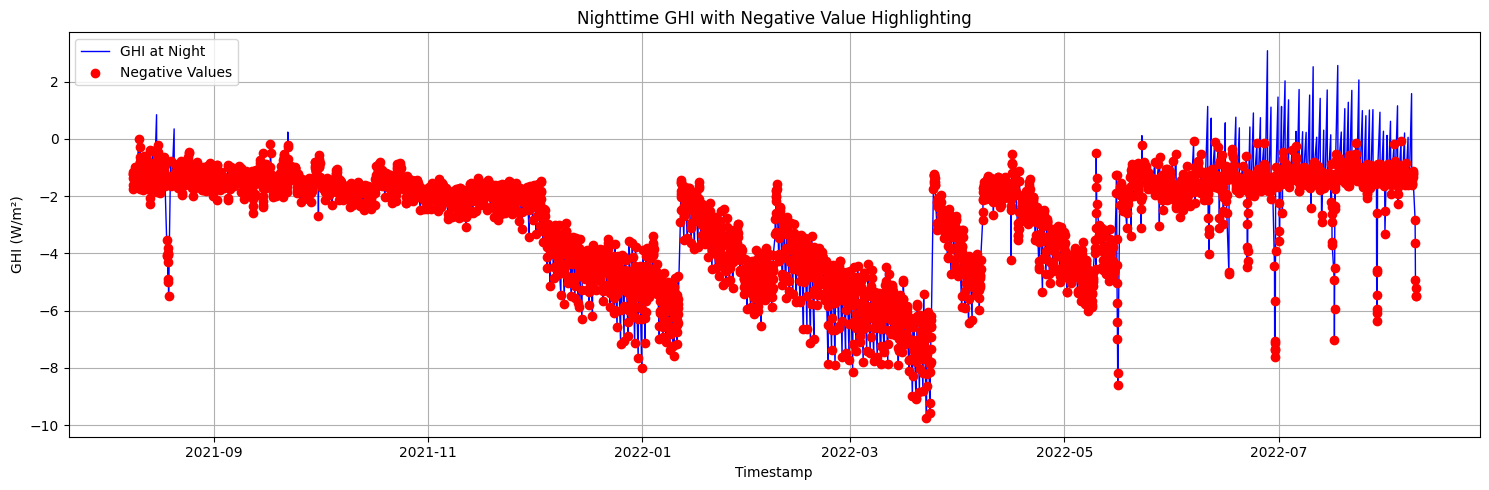

C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


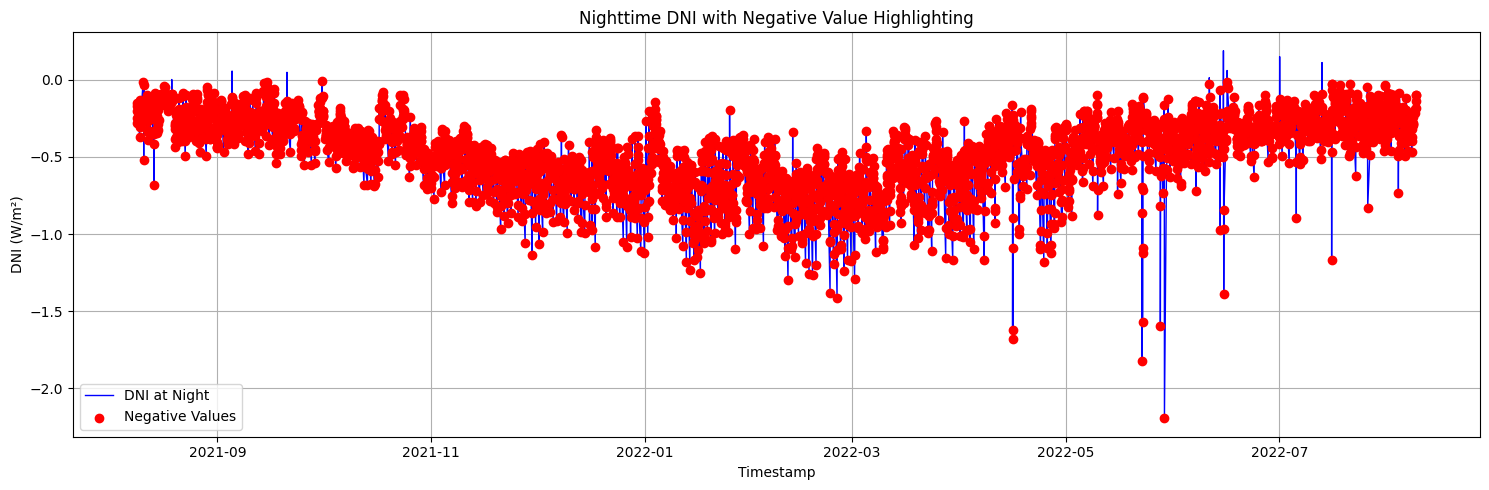

C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


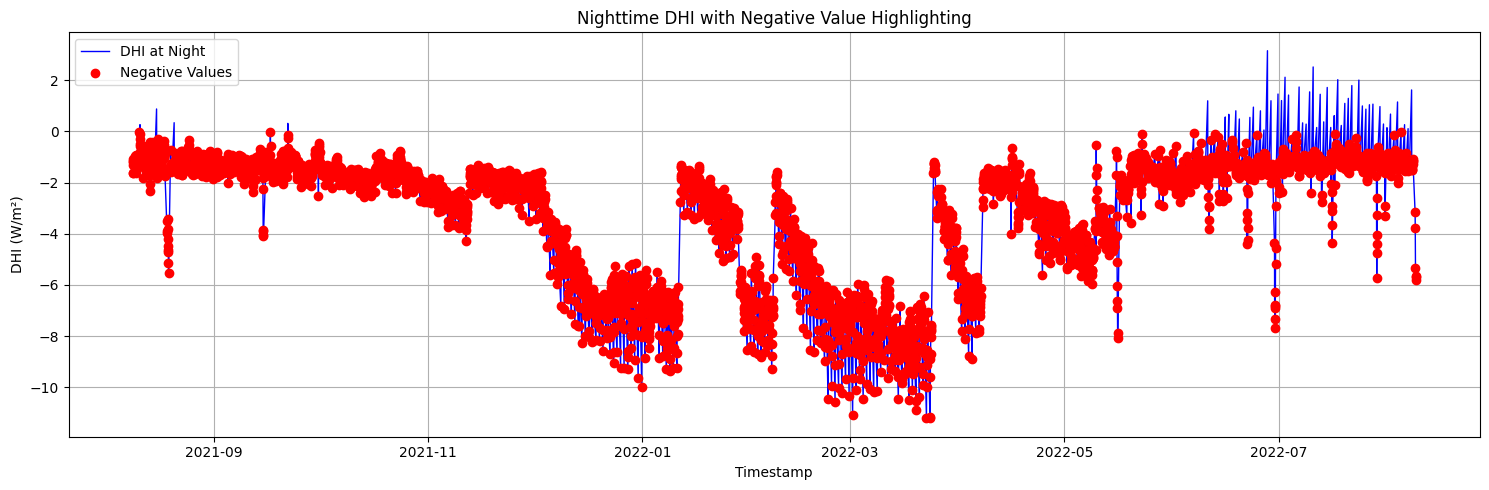

In [7]:
import pandas as pd
import matplotlib.pyplot as plt



# Loop through each irradiance component
for col in irradiance_cols:
    # Resample to hourly average
    df_hourly = df_benin[[col]].resample('H').mean()

    # Define hour and classify nighttime
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['is_night'] = ~df_hourly['hour'].between(6, 18)  # Night is before 6AM or after 6PM
    df_hourly['is_negative'] = df_hourly[col] < 0

    # Filter for nighttime data
    df_night = df_hourly[df_hourly['is_night']]

    # Plot irradiance during nighttime
    plt.figure(figsize=(15, 5))
    plt.plot(df_night.index, df_night[col], label=f'{col} at Night', color='blue', linewidth=1)

    # Highlight negative irradiance values
    negative_values = df_night[df_night['is_negative']]
    plt.scatter(negative_values.index, negative_values[col], color='red', label='Negative Values', zorder=3)

    # Add labels and show plot
    plt.title(f'Nighttime {col} with Negative Value Highlighting')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{col} (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 🌙 Nighttime Irradiance Values and Data Cleaning

It is clearly shown that the **negative values in GHI, DNI, and DHI** correspond to the **nighttime period**—when the sun is no longer visible and solar radiation should, by physics, be zero.

 Why This Happens
These negative values are not physically meaningful; they likely result from:
- **Sensor bias or drift** at night
- **Baseline miscalibration** of the equipment
- **Electronic noise** during low-light conditions

Since solar irradiance is **energy from sunlight**, it should never be negative. Even on cloudy days, irradiance may be low, but not below zero. At night, it should naturally be **zero**.


As a result, **all negative values in GHI, DNI, and DHI were safely replaced with 0**, aligning with real-world solar physics and making the dataset more reliable for analysis and modeling.

 Why This Matters
Cleaning these values:
- Improves the accuracy of statistical summaries
- Prevents skewing machine learning models in later phases
- Helps identify real solar potential without artificial noise



In [8]:
# Replace all invalid negatives with 0
df_benin[irradiance_cols] = df_benin[irradiance_cols].clip(lower=0)


make all -ve value of **irradiance_cols** to **0** for better analysis by using .clip(replace all values with lower 0 with 0 )

In [9]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), lower, upper

for col in ['ModA', 'ModB']:
    count, lower, upper = detect_outliers_iqr(df_benin[col])
    print(f"{col} → {count} outliers | Lower: {lower:.2f}, Upper: {upper:.2f}")


ModA → 98 outliers | Lower: -695.55, Upper: 1159.25
ModB → 240 outliers | Lower: -671.85, Upper: 1119.75


### Outlier Detection in Solar Sensor Data (ModA and ModB)

#### 🔍 Objective:
To identify unusually high or low readings (called **outliers**) in the solar panel sensor data, specifically from:

- **ModA** (clean module irradiance)
- **ModB** (soiled module irradiance)

Outliers can help us:
- Understand rare, peak solar conditions
- Detect potential sensor errors or extreme events
- Prepare the data for reliable modeling and reporting

---

#### Method Used: Interquartile Range (IQR)

The analysis uses a well-known statistical method called **IQR (Interquartile Range)** to define what is “too low” or “too high” compared to typical values.

Here’s how it works:
- **Q1** = the value below which the lowest 25% of readings fall
- **Q3** = the value below which the lowest 75% fall
- **IQR** = Q3 – Q1 → this tells us how spread out the "middle 50%" of data is

Using this, we define a normal range:
- Anything **below `Q1 - 1.5 × IQR`** or **above `Q3 + 1.5 × IQR`** is flagged as an outlier

---
As modeA and B have the minimum value > 0 , the result shows that
   
- **ModeA** = **98 outliers** are above the upperbound of ModeA which is **1159.25**
- **ModeB** = **240 outliers** are above the upperbound of ModeB which is **1119.75**


In [10]:

for col in ['WS', 'WSgust']:
    count, lower, upper = detect_outliers_iqr(df_benin[col])
    print(f"{col} → {count} outliers | Lower: {lower:.2f}, Upper: {upper:.2f}")

WS → 6717 outliers | Lower: -2.15, Upper: 6.25
WSgust → 5368 outliers | Lower: -2.90, Upper: 8.30


C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


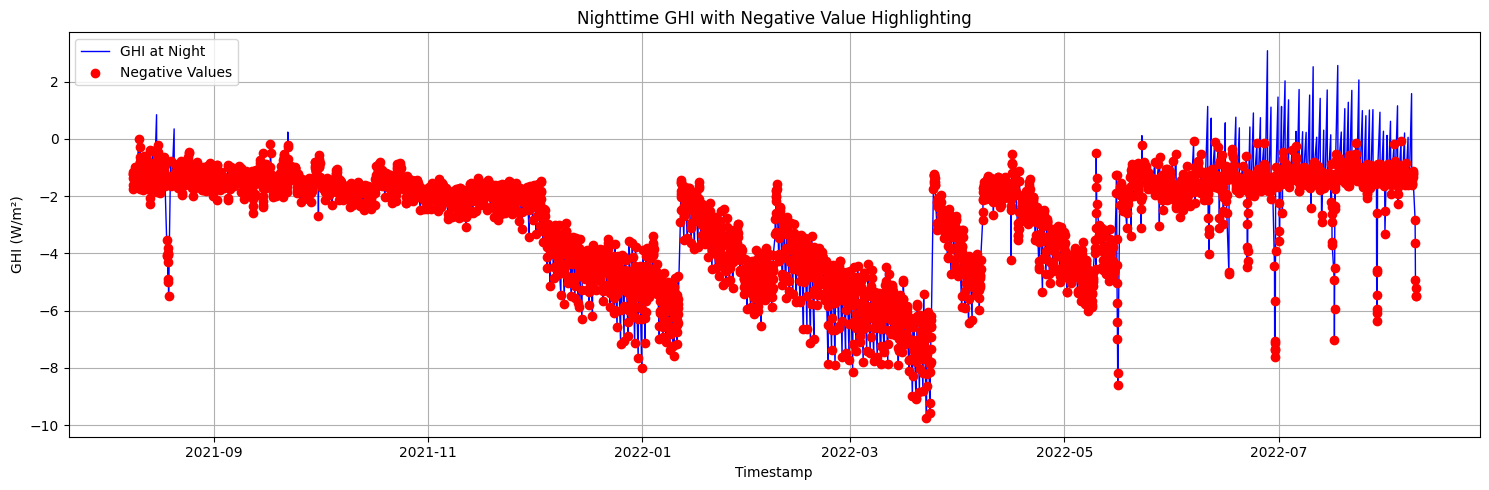

C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


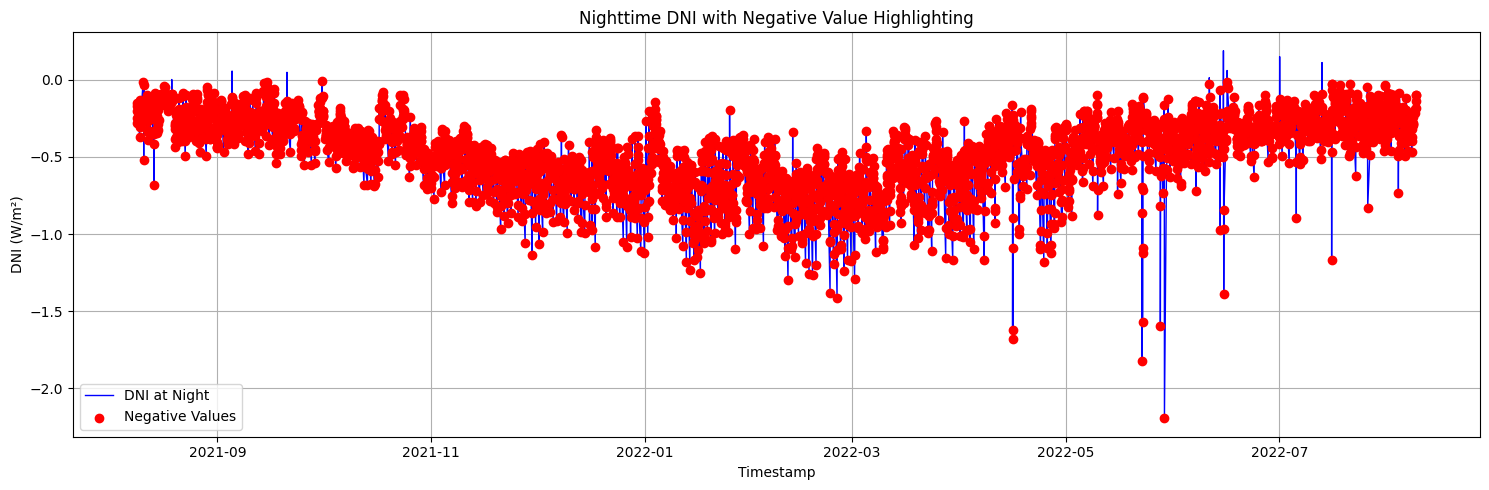

C:\Users\ABC\AppData\Local\Temp\ipykernel_15036\1021170375.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_benin[[col]].resample('H').mean()


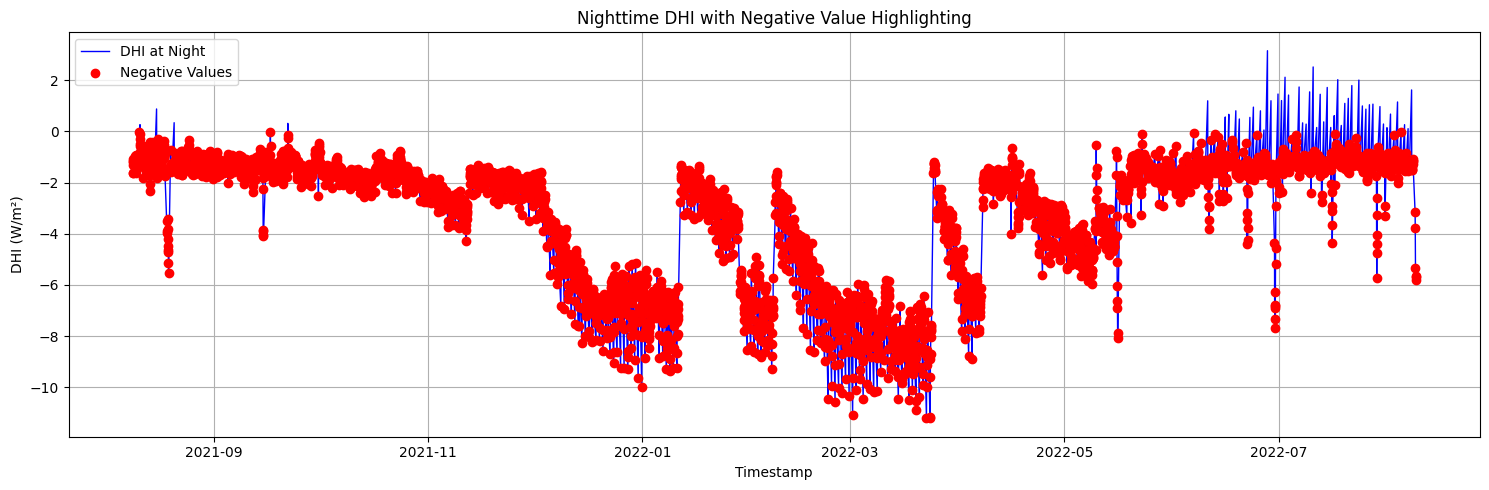

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Loop through each irradiance component
for col in irradiance_cols:
    # Resample to hourly average
    df_hourly = df_benin[[col]].resample('H').mean()

    # Define hour and classify nighttime
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['is_night'] = ~df_hourly['hour'].between(6, 18)  # Night is before 6AM or after 6PM
    df_hourly['is_negative'] = df_hourly[col] < 0

    # Filter for nighttime data
    df_night = df_hourly[df_hourly['is_night']]

    # Plot irradiance during nighttime
    plt.figure(figsize=(15, 5))
    plt.plot(df_night.index, df_night[col], label=f'{col} at Night', color='blue', linewidth=1)

    # Highlight negative irradiance values
    negative_values = df_night[df_night['is_negative']]
    plt.scatter(negative_values.index, negative_values[col], color='red', label='Negative Values', zorder=3)

    # Add labels and show plot
    plt.title(f'Nighttime {col} with Negative Value Highlighting')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{col} (W/m²)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


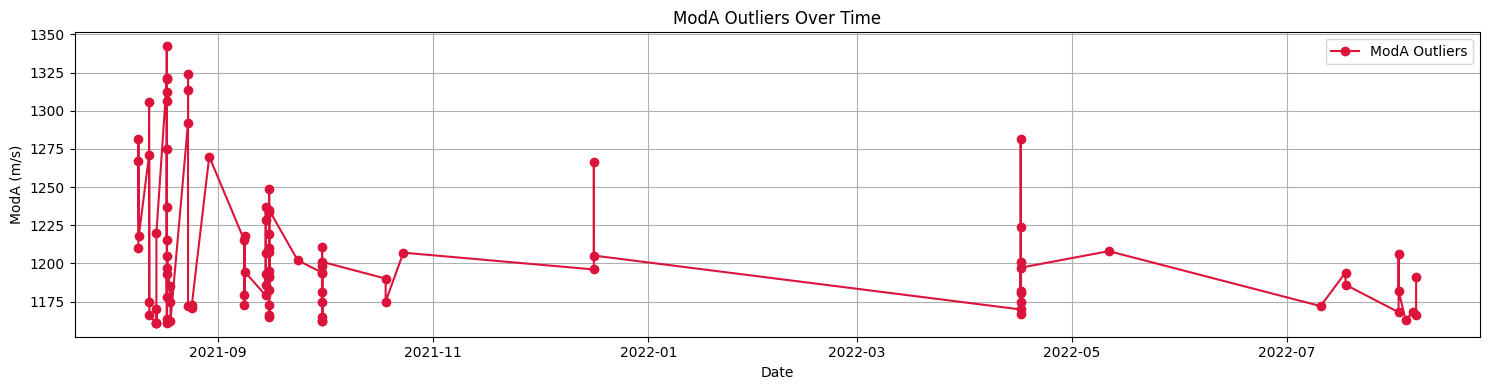

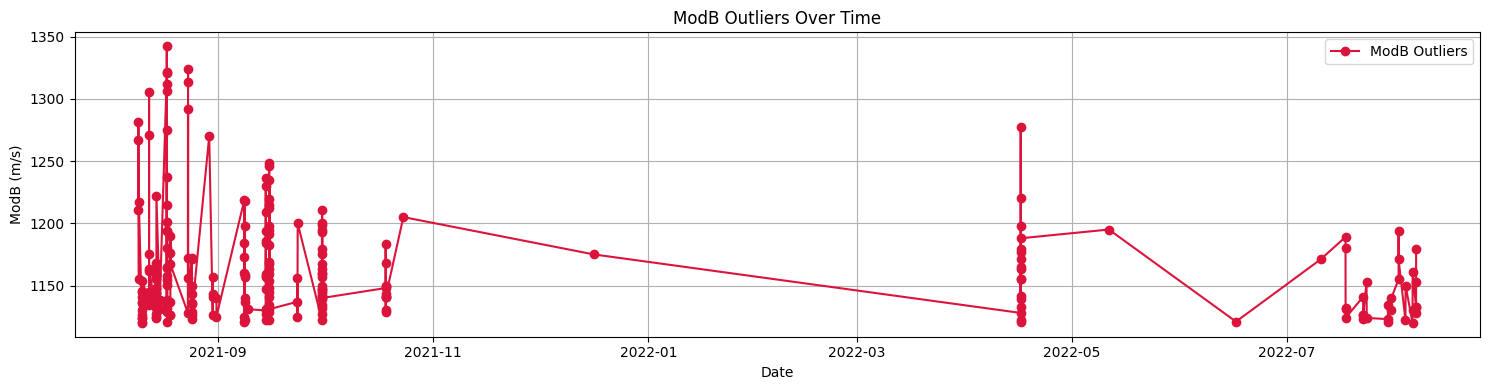

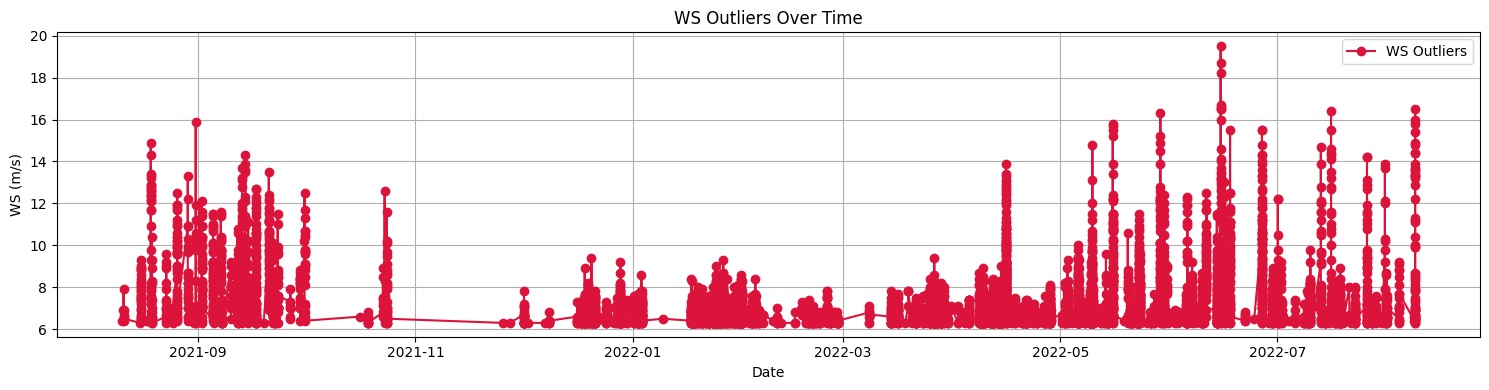

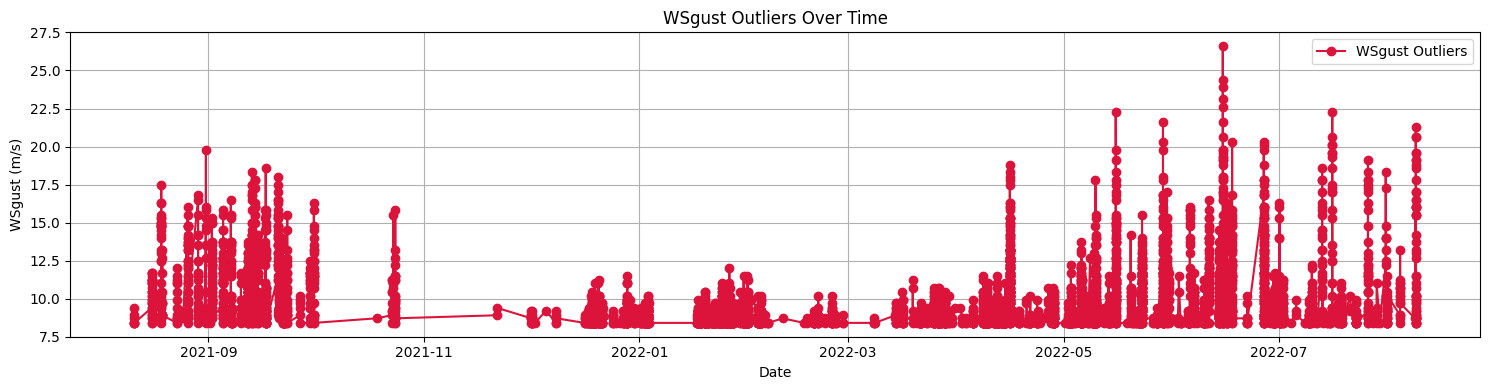

In [11]:
# Function to detect and plot outliers
def detect_and_plot_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR

    outliers = df[df[column] > upper]

    # Plot the outliers over time
    plt.figure(figsize=(15, 4))
    plt.plot(outliers.index, outliers[column], marker='o', linestyle='-', color='crimson', label=f'{column} Outliers')
    plt.title(f'{column} Outliers Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{column} (m/s)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for WS and WSgust
detect_and_plot_outliers(df_benin, 'ModA')
detect_and_plot_outliers(df_benin, 'ModB')
detect_and_plot_outliers(df_benin, 'WS')
detect_and_plot_outliers(df_benin, 'WSgust')

Based on weather Atlas information
##### Wind Seasonality in Malanville, Benin
###### Season	Period	Wind Speed (km/h)	Notes
 **>** High Wind	Late Nov – Early July	Up to 11.2 in Janwith (January being the peak)	Driven by Harmattan (dry desert winds)
**>**  Low Wind	July – Late Nov	~7.7 in Oct	Corresponds with wet/rainy season and lower irradiance

In [15]:
from scipy.stats import zscore
import numpy as np
#  Columns to compute Z-scores for
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

z_scores = df_benin[cols_to_check].apply(zscore)
# Step 2: Create a mask of where Z-scores are beyond the threshold
z_outlier_mask = np.abs(z_scores) > 3

# Step 3: Flag rows where any column is an outlier
rows_with_outliers = z_outlier_mask.any(axis=1)

# Step 4: Return original values AND which columns were the trigger
outlier_info = df_benin[rows_with_outliers].copy()
outlier_info['z_outlier_cols'] = z_outlier_mask[rows_with_outliers].apply(
    lambda row: ', '.join(row[row].index.tolist()), axis=1
)

# Show the first few rows
outlier_info[['z_outlier_cols'] + cols_to_check].head()

,z_outlier_cols,GHI,DNI,DHI,ModA,ModB,WS,WSgust
Timestamp,,,,,,,,
2021-08-09 11:11:00,DHI,836.0,235.0,610.6,778.8,783.8,3.2,4.1
2021-08-09 11:12:00,"GHI, DHI, ModB",1274.0,698.8,615.2,1210.3,1210.3,3.4,4.1
2021-08-09 11:13:00,DHI,938.0,340.1,612.8,891.1,891.1,3.4,4.6
2021-08-09 11:14:00,DHI,718.5,126.8,593.2,682.6,682.6,4.7,5.6
2021-08-09 11:15:00,"GHI, DHI, ModA, ModB",1349.0,771.8,618.0,1281.5,1281.5,4.0,4.6


### z score > 3 analysis
**→** Outliers appear in a continuous time block means likely a short burst of intense solar exposure, not random anomalies

**→**DHI appears in every row — showing it's the most volatile 

**→**Rows with high GHI, DNI, and ModA/ModB together showing clear sky solar spikes

**→**WS and WSgust never triggered Z > 3 means wind conditions are within stable range during these events